# Final Project

### 獲取歷史資料

In [1]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")

open = data.get("開盤價")
high = data.get("最高價")
low = data.get("最低價")
close = data.get("收盤價")
volume= data.get('成交股數')

rev.index = rev.index.shift(5, "d")

### 計算features

In [2]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

def yoy(n):
    return (rev / rev.shift(12)).shift(n)



features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'yoy': yoy(1),
    'delta_yoy':yoy(1)-yoy(2),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
}


### 製作dataset

##### 設定買賣頻率

In [3]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='date', length=211, freq=None)

##### 將dataframe 組裝起來

In [4]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [5]:

for name, f in features.items():
    features[name] = f.unstack()

In [6]:
import pandas as pd
dataset = pd.DataFrame(features)

In [7]:
feature_names = list(dataset.columns)

### 新增 label

In [8]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  all_index = (df.index | item.index).sort_values()
D:\Finlab\AI選股策略\finlab\data.py:103: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) inst

### 刪除太大太小的歷史資料

In [9]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','delta_yoy','yoy'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(428963, 31)
(399018, 31)


In [10]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [11]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='date', length=399018, freq=None)

In [12]:
dataset_train = dataset_dropna.loc[:'2020']
dataset_test = dataset_dropna.loc['2021':]

C:\Users\User\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


### 神經網路模型

In [13]:
import os

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=250, #1000
                    epochs=225, #225
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/225
598/598 [==============================] - ETA: 0s - loss: 0.205 - ETA: 0s - loss: 0.116 - ETA: 0s - loss: 0.097 - ETA: 0s - loss: 0.091 - ETA: 0s - loss: 0.088 - ETA: 0s - loss: 0.087 - ETA: 0s - loss: 0.085 - ETA: 0s - los

### 結果

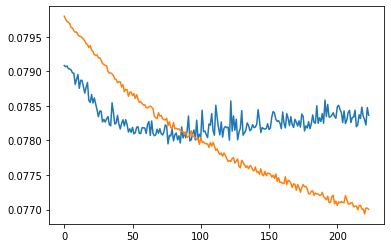

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [16]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(n_estimators=500)

### Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<AxesSubplot:xlabel='Value', ylabel='Feature'>

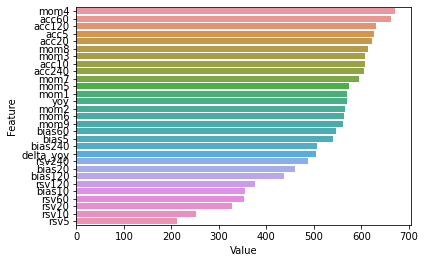

In [18]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [19]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

C:\Users\User\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\User\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\User\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

# backtest

<AxesSubplot:xlabel='date'>

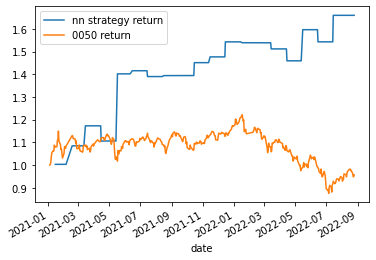

In [20]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','delta_yoy','yoy'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2021':].cumprod()

s0050 = close['0050']['2021':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [21]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='date', length=211, freq=None)

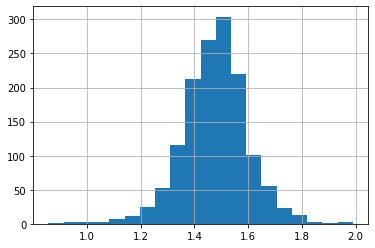

In [22]:
# get the latest dataset
last_date = "2022-07-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6','delta_yoy','yoy'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

# 平均分配資產於股票之中

In [23]:
close = data.get("收盤價")

money = 50000*4
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1104    0.453515
1233    0.292826
1325    0.367647
1473    0.445434
1503    0.158983
1720    0.206612
2029    0.389864
2069    0.422833
2206    0.280505
2471    0.364299
3498    0.359066
4535    0.269542
4737    0.112867
4804    0.881057
5016    0.312500
5520    0.178891
6263    0.127065
6411    0.088496
6616    0.583090
9962    0.630915
Name: 2022-08-25 00:00:00, dtype: float64